## Overview:
This project involves analyzing moderation networks on Mastodon by creating a similarity network based on moderation activities such as misinformation, hatespeech, spam, and harassment. By loading the dataset, calculating cosine similarities between instances, visualizing data using various graphs, and performing community detection to identify patterns in how moderation influences community structure, we will be able to analyze the data indepth.

# Creating a similarity network

A **sparse matrix** is one that uses less memory while storing and processing huge datasets since the majority of its elements are zero. Sparse matrices reduce computing complexity in operations like matrix multiplication by using specialized data structures to hold only the nonzero values and their places rather than all of the components. **Cosine similarity**, ranges from -1 to 1, and calculates the cosine of the angle between two vectors to determine how similar they are (scikit-learn, n.d.). It assists in detecting instances with similar patterns in moderation networks by comparing them according to their moderation behaviors. 

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   source           2724 non-null   int64 
 1   target           2724 non-null   int64 
 2   weight           2724 non-null   int64 
 3   blocking_reason  2724 non-null   object
dtypes: int64(3), object(1)
memory usage: 85.3+ KB
None

First 10 rows of the dataset:
   source  target  weight blocking_reason
0   24331   26285      50      harassment
1   24331   48838      36            spam
2   24331   58140      34  misinformation
3   24331   25479      71      harassment
4   24331   41216      81  misinformation
5   24331    4196      33  misinformation
6   24331    3790      59            spam
7   24331   51137      35  misinformation
8   24331   48286      41      harassment
9   24331   44447     118      hatespeech

Removed 0 rows with blank entries.

Sparse Matrix Created! S

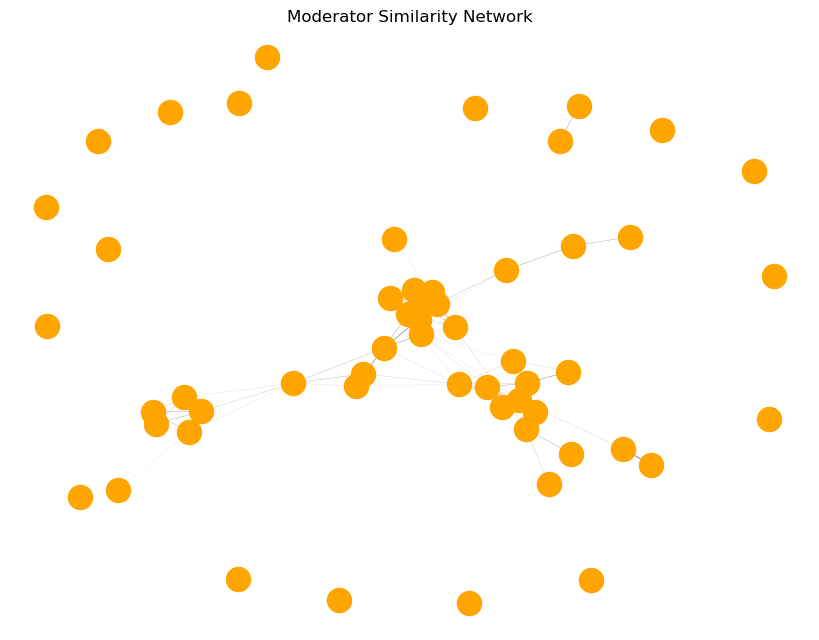

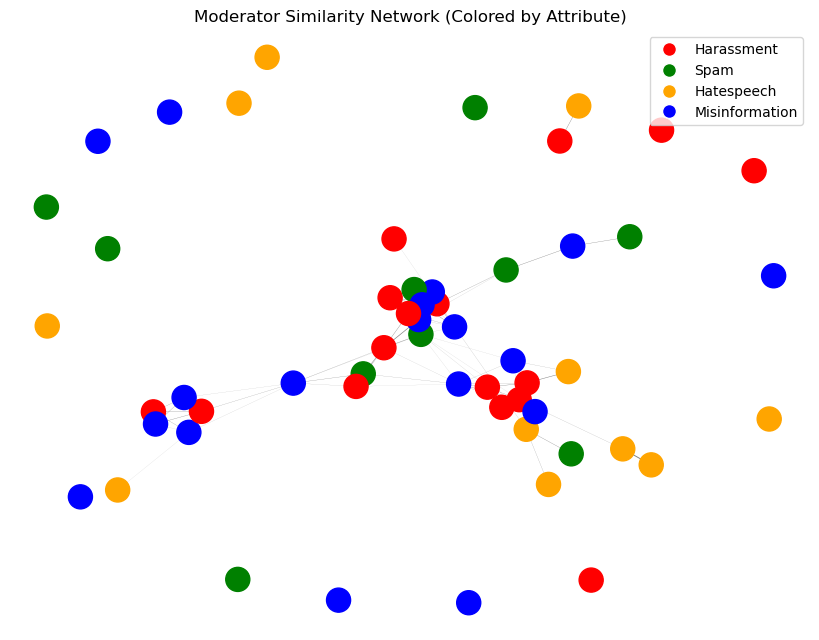

In [26]:
import re #for cleaning text
import pandas as pd #to use dataframe functions
import matplotlib.pyplot as plt #used for graphing
from matplotlib.lines import Line2D #used for the legend of similarity graph
import scipy.sparse as sp # used to calculate sparse matrices
import networkx as nx #used to create and analyze graphs
from sklearn.metrics.pairwise import cosine_similarity #used to compute cosine similarity


# To initially view the dataset
#df = pd.read_csv('mastodon_edgelist_AE2.csv')
#df.head(5)

class ModerationData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None #dataframe placeholder

    def load_data(self, column_name): #column to clean when loading data
        """
        Loads  dataset into a pandas DataFrame and displays basic info
        """
        self.df = pd.read_csv(self.file_path)

        #cleaning the data
        if column_name in self.df.columns:
            self.df[column_name] = self.df[column_name].apply(self.clean_text)
        else:
            print(f'Column "{column_name}" not found in dataset.')
        
        #displaying basic information for the dataset after cleaning
        print("Dataset Info:")
        print(self.df.info())
        print("\nFirst 10 rows of the dataset:")
        print(self.df.head(10))

    def clean_text(self, text):
        """
        Cleans the text by converting to lowercase and keeping only alphabetial letters
        """
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text) #keeps only alphabetical letters
        return text

    def empty_entries(self):
        """
        Removes rows with missing values in the 'blocking_reason' column
        """
        initial_count = len(self.df)
        self.df.dropna(subset=['blocking_reason'], inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        print(f'\nRemoved {initial_count - len(self.df)} rows with blank entries.\n')


    def moderation_reason(self, category): #Used for going above and beyond (Task 4)
        """
        Given a moderation reason, will filter the dataframe for just that reason
        """
        valid_categories = {'harassment', 'spam', 'hatespeech', 'misinformation'}
        if category not in valid_categories:
            print('Enter a valid moderation reason category. (harassment, spam, hatespeech, misinformation')
        else:
            filtered_df = self.df[self.df['blocking_reason'] == category] #filtering based on reason
            weighted_filtered_df = filtered_df.groupby(['source', 'target'])['weight'].sum().reset_index() #adding the weight if same source&target
            
            print(f'Filtered/weighted data for {category}:\n{weighted_filtered_df.head(5)}')
            print(f'\nFound {len(weighted_filtered_df)} moderated interactions for "{category}":')
           
            total_weight = weighted_filtered_df['weight'].sum() #add up the total weight of category
            print(f'Total weight: {total_weight}\n')
            
            return weighted_filtered_df

#sparse matrix indicates how many times moderator had to block/blocking reason
    def construct_sparse_matrix(self):
        """
        Constructs a sparse matrix where rows represent target nodes and columns represent source nodes.
        """
        #create pivot table with 'target' as rows, 'source' as columns' values as 'weight'. Filled with 0 if missing value
        pivot_df = self.df.pivot_table(index="target", columns="source", values="weight", fill_value=0)
        sparse_matrix = sp.csr_matrix(pivot_df.values)  #convert to sparse format using scipy
        print(f"Sparse Matrix Created! Shape: {sparse_matrix.shape}")
        return sparse_matrix

    def compute_cosine_similarity(self, sparse_matrix):
        """
        Computes cosine similarity between source nodes/moderators.
        """
        similarity_matrix = cosine_similarity(sparse_matrix.T)  #compute similarity
        moderators = self.df["source"].unique() # keeping only unique sources
        similarity_df = pd.DataFrame(similarity_matrix, index=moderators, columns=moderators) #creating a dataframe to store similarity values
        
        print("Cosine Similarity Matrix:")
        print(similarity_df.head(10))  #display first 10 rows
        return similarity_df

    def create_graph(self, similarity_df):
        """
        Creates an undirected weighted graph using the cosine similarity matrix.
        """
        G = nx.Graph()
        
        for moderator in similarity_df.index:
            G.add_node(moderator) #adding a node for each source
        
        for mod1 in similarity_df.index:
            for mod2 in similarity_df.index:
                if mod1 != mod2 and similarity_df.loc[mod1, mod2] > 0.05:  #threshold for edges
                    #lowered original threshhold from 2 to 0.05 to allow for more edges
                    G.add_edge(mod1, mod2, weight=similarity_df.loc[mod1, mod2])

        print(f"Graph Created! Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
        
        #draw graph
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G, seed=42)  #Fruchterman-Reingold Layout
        edges = G.edges(data=True)
        
        weights = [edge[2]['weight'] for edge in edges] #scaling the weights for visualization
        
        nx.draw(G, pos, with_labels=False, node_color="orange", edge_color='gray', 
                edge_cmap=plt.cm.Blues, width=weights, edge_vmin=0.2, edge_vmax=1)
        plt.title("Moderator Similarity Network")
        plt.show()

        return G


    def color_nodes_by_attribute(self, G):
        """
        Colors nodes based on the moderator's attribute.
        """
        attribute_map = {}
        for mod in G.nodes():
            matched_rows = self.df[self.df["source"] == mod]["blocking_reason"] #get blocking_reason values for each source
            if not matched_rows.empty:
                attribute_map[mod] = matched_rows.iloc[0] #assigning mod reason to attribute map
            else:
                attribute_map[mod] = "unknown"
        color_mapping = {"harassment": "red",
                        "spam": "green",
                        "misinformation": "blue",
                        "hatespeech": "orange",
                        "unknown": "gray"}  #gray color for missing values
        
        edges = G.edges(data=True)
        weights = [edge[2]['weight'] for edge in edges] #scaling the weights for visualization

        node_colors = [color_mapping.get(attribute_map.get(mod, "unknown"), "gray") for mod in G.nodes()] #assigning colors to nodes

        plt.figure(figsize=(8, 6))

        pos = nx.spring_layout(G, seed=42)  #Fruchterman-Reingold Layout
        
        nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color="gray", width=weights)
        
        #add a legend using matplot line2D
        legend_components = [Line2D([0], [0], marker='o', color='w', label='Harassment', markersize=10, markerfacecolor='red'),
                        Line2D([0], [0], marker='o', color='w', label='Spam', markersize=10, markerfacecolor='green'),
                        Line2D([0], [0], marker='o', color='w', label='Hatespeech', markersize=10, markerfacecolor='orange'),
                        Line2D([0], [0], marker='o', color='w', label='Misinformation', markersize=10, markerfacecolor='blue')]
        plt.legend(handles=legend_components, loc='best')

        plt.title("Moderator Similarity Network (Colored by Attribute)")
        plt.show()



#sample usage
moderation_data = ModerationData('mastodon_edgelist_AE2.csv')
#load moderation data
moderation_data.load_data('blocking_reason')
#filter missing entries
moderation_data.empty_entries()


#construct sparse matrix
sparse_matrix = moderation_data.construct_sparse_matrix()
#compute cosine similarity
similarity_df = moderation_data.compute_cosine_similarity(sparse_matrix)
#draw graph
G = moderation_data.create_graph(similarity_df)
#function call
moderation_data.color_nodes_by_attribute(G)

### Results
The cosine similarity matrix showed the connections between the nodes, with a value of 1 meaning exact similarity. I noticed that most of the entries were 0, meaning that many nodes have no similarity to eachother.
I also noticed that misinformation and harassment had instances that were most significant, by taking a close look at the first 10 rows of the dataset and seeing that misinformation and harassment together filled 7 of 10 rows. In addition, mods with similar blocking patterns had the most connections (edges), as shown by the similarity network graph.

I immediately noticed that I had removed 0 blank entries from the dataset, meaning there were no missing values.

My analysis reveals that Mastadon's moderation dynamics are strongly influenced by harassment and misinformation, with moderators displaying patterns of shared blocking behaviors across instances. This could show that moderators on Mastadon aim to collectively address misinformation and harassment as the most significant issues on the platform.

# Part 2
The Louvain Detection Algorithm is technique used to "extract the community structure of a network...based on modularity optimization." (NetWorkX, 2)

## New Methods in Part 2:
#### perform_louvain_community_detection
###### - Used to implement the Louvain Detection Algorithm 
##### summarize_community_info
###### - Used to summarize communities found from Louvain Detection Algorithm, like number of instances, etc.
##### plot_community_distribution
###### - Used to make a bar plot of the communities and instances


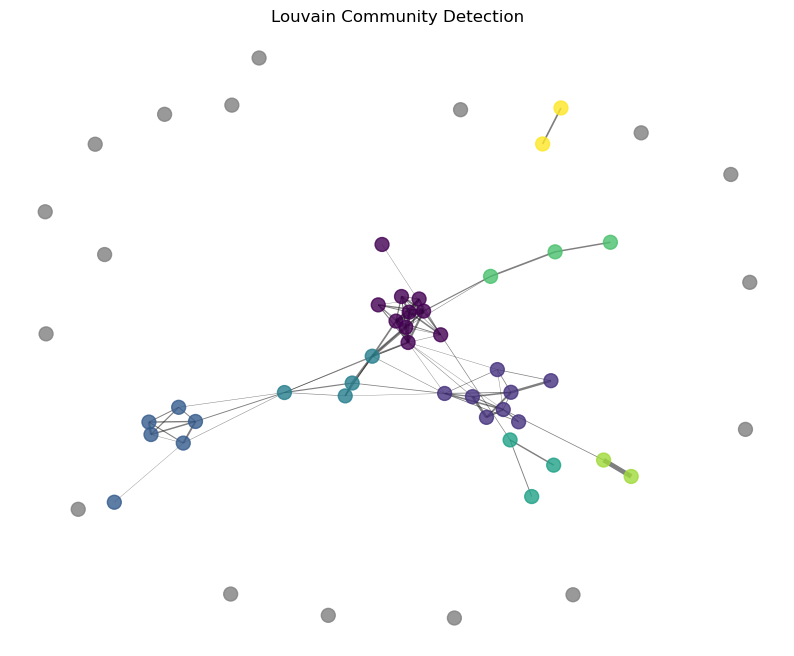


Summarized Community Information:
25 communities detected.

Community 1: 
 10 instances
 Nodes in community: [22144, 32421, 3687, 51240, 35721, 44559, 21007, 67859, 63892, 49630]
 Node with most edge connections: 35721

Community 2: 
 8 instances
 Nodes in community: [59904, 49537, 68485, 24331, 40846, 43633, 26643, 67191]
 Node with most edge connections: 26643

Community 3: 
 6 instances
 Nodes in community: [11376, 15189, 3813, 55898, 64266, 19420]
 Node with most edge connections: 11376

Community 4: 
 4 instances
 Nodes in community: [28680, 38313, 22540, 11487]
 Node with most edge connections: 11487

Community 5: 
 3 instances
 Nodes in community: [2448, 21089, 34039]
 Node with most edge connections: 34039

Community 6: 
 3 instances
 Nodes in community: [58360, 35130, 18988]
 Node with most edge connections: 35130

Community 7: 
 2 instances
 Nodes in community: [60509, 9613]
 Node with most edge connections: 60509

Community 8: 
 2 instances
 Nodes in community: [59721, 4812

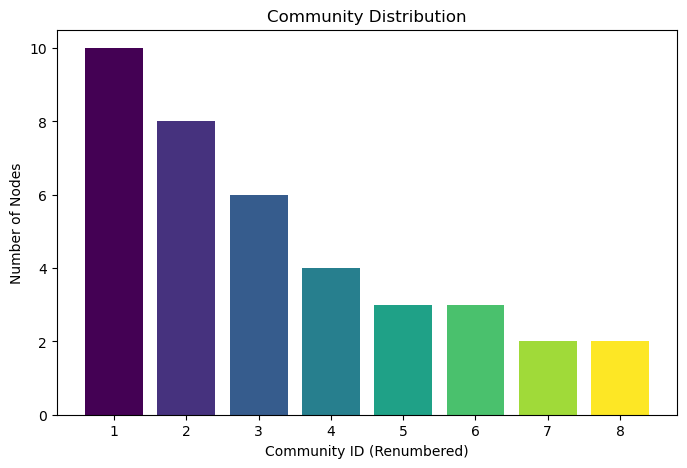

In [32]:

import re #for cleaning text
import pandas as pd #to use dataframe functions
import matplotlib.pyplot as plt #used for graphing
from matplotlib.lines import Line2D #used for the legend of similarity graph
import scipy.sparse as sp # used to calculate sparse matrices
import networkx as nx #used to create and analyze graphs
from sklearn.metrics.pairwise import cosine_similarity #used to compute cosine similarity



#packages for task 2
from collections import Counter #used to count number of nodes in each community
import numpy as np #used to color community detection


# To initially view the dataset
#df = pd.read_csv('mastodon_edgelist_AE2.csv')
#df.head(5)

class ModerationData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None #dataframe placeholder
        self.i = 0

    def load_data(self, column_name): #column to clean when loading data
        """
        Loads  dataset into a pandas DataFrame and displays basic info
        """
        self.df = pd.read_csv(self.file_path)

        #cleaning the data
        if column_name in self.df.columns:
            self.df[column_name] = self.df[column_name].apply(self.clean_text)
        else:
            print(f'Column "{column_name}" not found in dataset.')
        
        #displaying basic information for the dataset after cleaning

            #commenting out for task2
        #print("Dataset Info:")
        #print(self.df.info())
        #print("\nFirst 10 rows of the dataset:")
        #print(self.df.head(10))

    def clean_text(self, text):
        """
        Cleans the text by converting to lowercase and keeping only alphabetial letters
        """
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text) #keeps only alphabetical letters
        return text

    def empty_entries(self):
        """
        Removes rows with missing values in the 'blocking_reason' column
        """
        initial_count = len(self.df)
        self.df.dropna(subset=['blocking_reason'], inplace=True)
        self.df.reset_index(drop=True, inplace=True)
            #commenting out for task2
        #print(f'\nRemoved {initial_count - len(self.df)} rows with blank entries.')


    def moderation_reason(self, category):
        """
        Given a moderation reason, will filter the dataframe for just that reason
        """
        valid_categories = {'harassment', 'spam', 'hatespeech', 'misinformation'}
        if category not in valid_categories:
            print('Enter a valid moderation reason category. (harassment, spam, hatespeech, misinformation')
        else:
            filtered_df = self.df[self.df['blocking_reason'] == category] #filtering based on reason
            weighted_filtered_df = filtered_df.groupby(['source', 'target'])['weight'].sum().reset_index() #adding the weight if same source&target
            
            print(f'Filtered/weighted data for {category}:\n{weighted_filtered_df.head(5)}')
            print(f'\nFound {len(weighted_filtered_df)} moderated interactions for "{category}":')
           
            total_weight = weighted_filtered_df['weight'].sum() #add up the total weight of category
            print(f'Total weight: {total_weight}\n')
            
            return weighted_filtered_df

#sparse matrix indicates how many times moderator had to block/blocking reason
    def construct_sparse_matrix(self):
        """
        Constructs a sparse matrix where rows represent target nodes and columns represent source nodes.
        """
        #create pivot table with 'target' as rows, 'source' as columns' values as 'weight'. Filled with 0 if missing value
        pivot_df = self.df.pivot_table(index="target", columns="source", values="weight", fill_value=0)
        sparse_matrix = sp.csr_matrix(pivot_df.values)  #convert to sparse format using scipy
        print(f"Sparse Matrix Created! Shape: {sparse_matrix.shape}")
        return sparse_matrix

    def compute_cosine_similarity(self, sparse_matrix):
        """
        Computes cosine similarity between source nodes/moderators.
        """
        similarity_matrix = cosine_similarity(sparse_matrix.T)  #compute similarity
        moderators = self.df["source"].unique() # keeping only unique sources
        similarity_df = pd.DataFrame(similarity_matrix, index=moderators, columns=moderators) #creating a dataframe to store similarity values
        
        print("Cosine Similarity Matrix:")
        print(similarity_df.head(10))  #display first 10 rows
        return similarity_df

    def create_graph(self, similarity_df):
        """
        Creates an undirected weighted graph using the cosine similarity matrix.
        """
        G = nx.Graph()
        
        for moderator in similarity_df.index:
            G.add_node(moderator) #adding a node for each source
        
        for mod1 in similarity_df.index:
            for mod2 in similarity_df.index:
                if mod1 != mod2 and similarity_df.loc[mod1, mod2] > 0.05:  #threshold for edges
                    #lowered original threshhold from 2 to 0.05 to allow for more edges
                    G.add_edge(mod1, mod2, weight=similarity_df.loc[mod1, mod2])

        print(f"Graph Created! Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
        
        #draw graph
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G, seed=42)  #Fruchterman-Reingold Layout
        edges = G.edges(data=True)
        
        weights = [edge[2]['weight'] for edge in edges] #scaling the weights for visualization
        
        nx.draw(G, pos, with_labels=False, node_color="orange", edge_color='gray', 
                edge_cmap=plt.cm.Blues, width=weights, edge_vmin=0.2, edge_vmax=1)
        plt.title("Moderator Similarity Network")
        plt.show()

        return G


    def color_nodes_by_attribute(self, G):
        """
        Colors nodes based on the moderator's attribute.
        """
        attribute_map = {}
        for mod in G.nodes():
            matched_rows = self.df[self.df["source"] == mod]["blocking_reason"] #get blocking_reason values for each source
            if not matched_rows.empty:
                attribute_map[mod] = matched_rows.iloc[0] #assigning mod reason to attribute map
            else:
                attribute_map[mod] = "unknown"
        color_mapping = {"harassment": "red",
                        "spam": "green",
                        "misinformation": "blue",
                        "hatespeech": "orange",
                        "unknown": "gray"}  #gray color for missing values
        
        edges = G.edges(data=True)
        weights = [edge[2]['weight'] for edge in edges] #scaling the weights for visualization

        node_colors = [color_mapping.get(attribute_map.get(mod, "unknown"), "gray") for mod in G.nodes()] #assigning colors to nodes

        plt.figure(figsize=(8, 6))

        pos = nx.spring_layout(G, seed=42)  #Fruchterman-Reingold Layout
        
        nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color="gray", width=weights)
        
        #add a legend using matplot line2D
        legend_components = [Line2D([0], [0], marker='o', color='w', label='Harassment', markersize=10, markerfacecolor='red'),
                        Line2D([0], [0], marker='o', color='w', label='Spam', markersize=10, markerfacecolor='green'),
                        Line2D([0], [0], marker='o', color='w', label='Hatespeech', markersize=10, markerfacecolor='orange'),
                        Line2D([0], [0], marker='o', color='w', label='Misinformation', markersize=10, markerfacecolor='blue')]
        plt.legend(handles=legend_components, loc='best')

        plt.title("Moderator Similarity Network (Colored by Attribute)")
        plt.show()

################################################## Task 2 #####################################################

    def perform_louvain_community_detection(self, G):
        """
        Performs community detection using the Louvain algorithm.
        """
        communities = nx.community.louvain_communities(G, seed=42)
        
        #assign each node to a community
        node_community_map = {}
        for i, comm in enumerate(communities):
            for node in comm:
                node_community_map[node] = i  #assign each node a community ID

        #count the number of nodes in each community
        community_sizes = Counter(node_community_map.values())

        #define the threshold (e.g., exclude communities with fewer than 3 nodes)
        threshold = 2
        filtered_communities = {k: v for k, v in community_sizes.items() if v >= threshold}

        #sort the filtered communities by largest to smallest size and reassign IDs from 1 to n
        sorted_communities = sorted(filtered_communities.items(), key=lambda x: x[1], reverse=True)
        reassigned_community_map = {old_id: new_id for new_id, 
                                    (old_id, _) in enumerate(sorted_communities, start=1)}

        #update node colors for visualization
        num_filtered_comms = len(sorted_communities)
        community_colors = plt.cm.viridis(np.linspace(0, 1, num_filtered_comms)) #use numpy to assign colors to communities

        #reassign community labels only for remaining communities
        node_colors_community = [community_colors[reassigned_community_map[node_community_map[n]] - 1] 
            if node_community_map[n] in filtered_communities else "gray"
            for n in G.nodes()]

        #compute FR layout for visualization
        pos_sim = nx.spring_layout(G, seed=42)

        #visualize communities by color for louvain community detection
        if self.i==0: #this plot will only print the first time the method is ever called. Done to prevent reprints
            plt.figure(figsize=(10, 8))
            nx.draw_networkx_nodes(G, pos_sim, node_color=node_colors_community, node_size=100, alpha=0.8)
            nx.draw_networkx_edges(G, pos_sim, width=[G[u][v]['weight'] * 5 for u, v in G.edges()], alpha=0.5) #edge size proportional to weight

            plt.title("Louvain Community Detection")
            plt.axis('off')
            plt.show()
            
            self.i+=1 #so the graph only prints a total of 1 time
            
        return node_community_map, node_colors_community


    def summarize_community_info(self, G):
        """
        Using the perform_louvain_community detection method, summarizes the detected Louvain communities.
        """
        # perform louvain community detection
        node_communities, _ = self.perform_louvain_community_detection(G)
         # count nodes in each community
        community_sizes = Counter(node_communities.values())

        # sort from largest to smallest by community size
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

        print("\nSummarized Community Information:")
        print(f"{len(sorted_communities)} communities detected.")

       
        for i, (community, size) in enumerate(sorted_communities[:8]): # 8 is the number of communities above threshold
            community_nodes = [node for node, c in node_communities.items() if c == community]

            #number of instances in community
            community_instances = sum(1 for u, v in G.edges() if u in community_nodes and v in community_nodes)
        
            # finding the instance with most connections
            most_edges = max(community_nodes, key=lambda n: G.degree(n))

            print(f'\nCommunity {i+1}: \n {size} instances')
            print(f' Nodes in community: {community_nodes}')
            print(f' Node with most edge connections: {most_edges}')
        
            #since the communities are sorted, from largest to smallest, the largest is at index 0
        print(f'\nCommunity with most instances: Community {sorted_communities.index(sorted_communities[0]) + 1}') 
            #+1 since 0 index is community 1 but will print community 0 without the plus 1
        
        
    def plot_community_distribution(self, G):
        """
        Creates a bar plot of community distribution from Louvain Algorithm
        """
        # perform louvain community detection
        node_communities, node_colors_community = self.perform_louvain_community_detection(G)

        community_sizes = Counter(node_communities.values()) #using Counter to find total number of nodes in each community

        # filter out small communities
        threshold = 2  # number of nodes to be considered 
        filtered_communities = {k: v for k, v in community_sizes.items() if v >= threshold}

        # sort communities by size
        sorted_communities = sorted(filtered_communities.items(), key=lambda x: x[1], reverse=True)

        # reassigning community IDs from 1 to n
        reassigned_community_map = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_communities, start=1)}

        num_filtered_comms = len(sorted_communities)
        community_colors = plt.cm.viridis(np.linspace(0, 1, num_filtered_comms)) #assigning colors to communities

        

        #plotting
        plt.figure(figsize=(8, 5))
        plt.bar([reassigned_community_map[old_id] for old_id, _ in sorted_communities],  # Renumbered community IDs
                [size for _, size in sorted_communities],  # Sorted community sizes
                color=[community_colors[i - 1] for i in range(1, num_filtered_comms + 1)]
        )

        plt.xlabel("Community ID (Renumbered)")
        plt.ylabel("Number of Nodes")
        plt.title(f"Community Distribution")
        plt.xticks(range(1, num_filtered_comms + 1))  #x-axis ticks start from 1
        plt.show()
            




#sample usage
moderation_data = ModerationData('mastodon_edgelist_AE2.csv')
#load moderation data
moderation_data.load_data('blocking_reason')
#filter missing entries
moderation_data.empty_entries()

# commented out for task 2
#construct sparse matrix
#sparse_matrix = moderation_data.construct_sparse_matrix()
#compute cosine similarity
#similarity_df = moderation_data.compute_cosine_similarity(sparse_matrix)
#draw graph
#G = moderation_data.create_graph(similarity_df)
#function call
#moderation_data.color_nodes_by_attribute(G)


### Task 2 outputs
# perform Louvain community detection
moderation_data.perform_louvain_community_detection(G)
# summarize community information
moderation_data.summarize_community_info(G)
# call plot community distribution:
moderation_data.plot_community_distribution(G)

### Results
After analyzing the distribution of nodes among the communities, I noticed variation in the community size. Of the total detected communities, most contained 3 or less nodes, with only communities 1-4 containing 4+ nodes. This hows that the communities are mostly smaller and isolated, expressed by the grey nodes on the outside towards the outside of the graph. However, the few large communities are very active within thier users.

# Part 4: Going Above And Beyond
For this part, I realized I had misinterpreted a part in task 1, so I decided I could use the method, **moderation_reason**, here to analyze the data further beyond task 1 and 2.
I also looked back through passed lectures and realized I wanted to implement an **interaction matrix** as it is another good way to indicate interaction and similarity between nodes.

In [11]:
#filtering data by a category
harassment_filtered_df = moderation_data.moderation_reason('harassment')
spam_filtered_df = moderation_data.moderation_reason('spam')
hatespeech_filtered_df = moderation_data.moderation_reason('hatespeech')
misinformation_filtered_df = moderation_data.moderation_reason('misinformation')



#Interaction Matrix
interaction_matrix = nx.to_numpy_array(G, dtype=float) #create the interaction matrix
interaction_matrix = np.round(interaction_matrix, 3)

print('\n\nInteraction Matrix:')
print(f'     Matrix Shape:" {interaction_matrix.shape}\n')
print(f'10x10 Submatrix: \n{interaction_matrix[:10, :10]}')  # show the top left 10x10 submatrix

Filtered/weighted data for harassment:
   source  target  weight
0    2448    9403     107
1    2448   12110      54
2    2448   20808      32
3    2448   32188      52
4    2448   73387      98

Found 678 moderated interactions for "harassment":
Total weight: 43849

Filtered/weighted data for spam:
   source  target  weight
0    2448     542      32
1    3687   35347      44
2    3687   42211      94
3    3687   63676      37
4    3813   32476      34

Found 685 moderated interactions for "spam":
Total weight: 48828

Filtered/weighted data for hatespeech:
   source  target  weight
0    2448   25278      50
1    2448   48895      68
2    2448   58882      35
3    3765   12110      31
4    3813   15028     157

Found 667 moderated interactions for "hatespeech":
Total weight: 46860

Filtered/weighted data for misinformation:
   source  target  weight
0    2448     519      32
1    2448   11802      33
2    2448   31587      37
3    3687   39033      31
4    3687   56055     102

Found 69

### Results:
Using the 4 separately filtered datasets, I found that misinformation had the most instances of the four categories with 694 interactions while spam had the highest total weight with 46948. I noticed that hatespeech had the lowest interactions with 667 interactions, but had a higher weight than harassment by around 3000 even though harassment has 678 interactions.

The interaction matrix is mostly sprarse (mostly 0's), showing that most entries don't have interactions with each other. The non-zero values most likely show weighted interactions and can be used to analyze and detect communities. I also noticed that it is the almost the same matrix as the cosine similarity one, except the diagnonals of the interaction matrix are zeros insead of ones since a node doesn't interact with itself.

# Task 3: Reflection

For most of the second half of task one, I regularly referenced code from previous labs since I couldn’t recall how to compute cosine similarity and the sparse matrix from scratch. I had to recheck the lecture slides when figuring out what the cosine similarity meant and how it was computed, along with my research, watching videos, and reading articles.

At first, when printing the Moderator Similarity Network (Colored by Attribute) graph, I couldn’t figure out why there were so few edges. After messing around with the method, I realized that changing the threshold changed the number of connections between nodes, so I decreased it so more edges would be made. However, for the community threshold, I kept it at 2 because less than that is too few for a community.

Also, I had trouble getting the colors to display on the graph. Either all the nodes would be gray, the 'unknown' color, or all a different color. I was able to debug this by using print statements of my attribute map and node_colors to find out where the error was happening. I ended up implementing a for loop in the method that allowed the colors to correctly show on the graph.

Again, with task two, I struggled conceptually with the code since I hadn’t seen these algorithms before, especially because the code was given to us and ran fine after copying and pasting. After research, however, I slowly started to understand each line and how the Louvain algorithm worked.
The biggest challenge in task two was, surprisingly, getting the outputs to display correctly. The Louvain community detection graph would print three times instead of once, since every time I called the perform_louvain_community_detection method in the summarize and plotting methods, the graph would be printed, giving a total of three graphs. After some trial and error, I initialized a variable in the constructor class, i = 0, and set it so that the graph would only print if i = 0, and after the first time printing, i is changed to equal 1.

Overall, this assignment provided valuable experience in implementing network analysis techniques, debugging, and understanding complex code. I learned the importance of referencing prior work to reinforce my understanding, as well as troubleshooting errors using print statements to gradually catch issues. I also gained a deeper appreciation for how parameter selection impacts graph structures and community detection results. In the future, I will focus on developing a clearer conceptual understanding of algorithms before implementing them, structuring my code to minimize redundant outputs, and exploring the dataset further in the "Go Above and Beyond" section.

# References:
Matplotlib.org. (2025). matplotlib.lines.Line2D — Matplotlib 3.10.1 documentation. [online] Available at: https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html.

networkx.org. (n.d.). louvain_communities — NetworkX 3.2.1 documentation. [online] Available at: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html.

scikit-learn. (n.d.). sklearn.metrics.pairwise.cosine_similarity. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html.

Intermediate Programming with Data AE2 Data file (csv file). Available at:
https://nulondon.instructure.com/courses/4548/pages/ae2-data-file?module_item_id=377107


Intermediate Programming with Data Lecture 9: Graphs and Network Analysis. Available at:
https://nulondon.instructure.com/courses/4548/pages/week-9-lecture?module_item_id=376952


Intermediate Programming with Data Week 9 - Lab Solution. Available at:
https://nulondon.instructure.com/courses/4548/pages/week-9-lab-solution?module_item_id=377278


Intermediate Programming with Data Sample Guide for Network Visualisation. Available at:
https://nulondon.instructure.com/courses/4548/pages/sample-guide-for-network-visualisation?module_item_id=377168